In [1]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'zh'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'without'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [9]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=False, inspect_samples=3)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.19, Train BLEU: 0.00, Val BLEU: 0.02, Minutes Elapsed: 0.12
Sampling from val predictions...
Source: 我 生活 在 洛杉矶 <UNK> <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: i live in south central . <EOS> <PAD> <PAD>
Model: <SOS> videodisc . . . . . . . .

Source: 那双 被 <UNK> 了 的 手 属于 这家 的 父亲
Reference: the dyed black hands are the father , while
Model: <SOS> adversities the the the the the the the the

Source: 一个 奄奄 奄奄一息 一息 的 女人 正 躺 在 地上
Reference: a lifeless woman was lying on the ground ,
Model: <SOS> the the the the the the the the the



Epoch: 0.15, Train Loss: 0.00, Val Loss: 6.09, Train BLEU: 0.00, Val BLEU: 2.97, Minutes Elapsed: 11.63
Sampling from val predictions...
Source: 我 11 岁 那年 记得 得有 一天 早晨 醒来 听见
Reference: when i was 11 , i remember waking up
Model: <SOS> and &apos;s , , , , , , ,

Source: 碰巧 一年 年后 我们 又 回到 了 纽约 纽约市 所以
Reference: we happened to be back in new york exactly
Model: <SOS> and , , , , , , , ,

Source: 举 个例 例子 我 所 住 的 街区 的 肥胖
Reference: for instance , the obesity rate in my neighborhood
Model: <SOS> and &apos;s , , , , , , ,



Epoch: 0.30, Train Loss: 0.00, Val Loss: 6.00, Train BLEU: 0.00, Val BLEU: 4.09, Minutes Elapsed: 23.37
Sampling from val predictions...
Source: 这 就是 这个 项目 目的 全部 为了 恢复 人性 中
Reference: that &apos;s all this project was about , about
Model: <SOS> it &apos;s a to the . . . .

Source: 用 <UNK> 冷藏 食物 也 非 长久 <UNK> 久之 计
Reference: <UNK> way of maintaining things is not sustainable .
Model: <SOS> it &apos;s <UNK> <UNK> <UNK> <UNK> the . the

Source: 我 想 通过 一个 叫做 <UNK> 的 作品 来看 看看
Reference: i want to look into corruption in afghanistan through
Model: <SOS> it &apos;s a to <UNK> the . . .



Epoch: 0.45, Train Loss: 0.00, Val Loss: 5.85, Train BLEU: 0.00, Val BLEU: 2.98, Minutes Elapsed: 35.23
Sampling from val predictions...
Source: 我 要 回答 下人 人们 常常 问 我 的 那些
Reference: and i &apos;m going to answer the questions that
Model: <SOS> and &apos;s &apos;s to to to the the of

Source: 一些 朝鲜 <UNK> 在 中国 到 外国 国大 大使 大使馆
Reference: some north koreans in china seek asylum in foreign
Model: <SOS> and , the the the , the the the

Source: 每年 无数 的 朝鲜 <UNK> 在 中国 被捕 并 被
Reference: every year , countless north koreans are caught in
Model: <SOS> and , , the the the the the the



Epoch: 0.60, Train Loss: 0.00, Val Loss: 5.74, Train BLEU: 0.00, Val BLEU: 2.02, Minutes Elapsed: 47.05
Sampling from val predictions...
Source: 那么 结果 呢 40 年 之后 1900 年 美利 美利坚
Reference: so what happens ? in 40 years &apos; time
Model: <SOS> so , i i the i , , ,

Source: 它们 是 那么 的 优雅 查尔斯 尔斯 达尔 达尔文 曾
Reference: they are very graceful . charles darwin said he
Model: <SOS> so i a a , , , , ,

Source: 我们 <UNK> 了 奴隶 奴隶制 奴隶制度 制度 而 此时 我
Reference: we started talking about slavery , and really ,
Model: <SOS> and <UNK> a to , , , , ,



Epoch: 0.75, Train Loss: 0.00, Val Loss: 5.66, Train BLEU: 0.00, Val BLEU: 4.62, Minutes Elapsed: 58.44
Sampling from val predictions...
Source: 这些 井 有 差不多 不多 有 90 多米 深 他们
Reference: the shafts are up to 300 feet deep ,
Model: <SOS> and , , the , the , the <EOS>

Source: 27 岁 时 我 做出 一个 决定 只 基于 人们
Reference: i decided when i was 27 years old to
Model: <SOS> it , , to , , , , ,

Source: 现在 就 像 爱 <UNK> 顿 博士 一个 科学 科学家
Reference: now , like doc <UNK> , a scientist himself
Model: <SOS> and , the &apos;s , the , , ,



Epoch: 0.90, Train Loss: 0.00, Val Loss: 5.53, Train BLEU: 0.00, Val BLEU: 3.17, Minutes Elapsed: 69.92
Sampling from val predictions...
Source: 而且 它 的 意思 是 一个 <UNK> 的 政客 <EOS>
Reference: and what <UNK> means is &quot; a dishonest politician
Model: <SOS> they , , the is the . &quot; .

Source: 如果 听完 这些 她们 还是 说 不 不 cameron 我
Reference: if , after this amazing list , they still
Model: <SOS> and , have you , , , the ,

Source: 这 就是 为什么 什么 在 <UNK> <UNK> 10 年后 我
Reference: that &apos;s why , after 10 years of hiding
Model: <SOS> this &apos;s the , &apos;s &apos;s , , ,



Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.47, Train BLEU: 0.00, Val BLEU: 5.19, Minutes Elapsed: 77.73
Sampling from val predictions...
Source: 事实 事实上 这项 实验 得到 的 结论 是 如果 我们
Reference: so actually , the conclusion from this research is
Model: <SOS> and , , the &apos;s of that , ,

Source: 我 养 了 一只 黑色 <UNK> 拉布 <UNK> 布拉 拉多
Reference: i have that black lab , and i have
Model: <SOS> i i a to a , , , ,

Source: 据估计 估计 有 超过 4000 名儿 儿童 在 沃尔特 尔特
Reference: it &apos;s estimated that more than 4,000 children are
Model: <SOS> why : a a the &apos;s , , &apos;s



Epoch: 1.15, Train Loss: 0.00, Val Loss: 5.44, Train BLEU: 0.00, Val BLEU: 4.64, Minutes Elapsed: 89.98
Sampling from val predictions...
Source: 但 我 并 没有 因此 放弃 我 坚持 坚持不懈 不懈
Reference: so i didn &apos;t give up . i continued
Model: <SOS> but i i &apos;t know that , i i

Source: 康 纳 并 不是 回到 家 向 我 宣布 嘿
Reference: now , <UNK> did not come home one day
Model: <SOS> and , the &apos;s , , , the ,

Source: 另外 当 你们 描述 科学 原理 时 要 注意 术语
Reference: and when you &apos;re describing your science , beware
Model: <SOS> and , you &apos;re that to , , ,



Epoch: 1.30, Train Loss: 0.00, Val Loss: 5.40, Train BLEU: 0.00, Val BLEU: 4.97, Minutes Elapsed: 102.03
Sampling from val predictions...
Source: 你 想 过为 为什么 什么 点 <UNK> 符号 <UNK> 子弹
Reference: have you ever wondered why they &apos;re called bullet
Model: <SOS> you you you to <UNK> &quot; &apos;s to to

Source: 从 声音 里 我们 可以 追寻 <UNK> 声 <UNK> 颤动
Reference: from the sound , we can actually track the
Model: <SOS> and , , , we we to to the

Source: 的 一些 人 实际 实际上 在 说 这 是 她
Reference: is code for some people for , &quot; it
Model: <SOS> and &apos;s a the , , the , ,



Epoch: 1.45, Train Loss: 0.00, Val Loss: 5.33, Train BLEU: 0.00, Val BLEU: 5.30, Minutes Elapsed: 113.46
Sampling from val predictions...
Source: 这 是 南 洛杉矶 笑 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: this is south los angeles . <EOS> <PAD> <PAD>
Model: <SOS> that &apos;s a . . <EOS> <EOS> <EOS> <EOS>

Source: 我们 总是 没有 <UNK> 勇气 谈论 死亡 甚至 没有 <UNK>
Reference: death is something that we &apos;re often discouraged to
Model: <SOS> we we we we we &apos;re to to .

Source: 人们 把 收集 到 的 照片 送到 那个 <UNK> <UNK>
Reference: this is where people were handing them in ,
Model: <SOS> and , the of of the . . .



Epoch: 1.60, Train Loss: 0.00, Val Loss: 5.30, Train BLEU: 0.00, Val BLEU: 3.99, Minutes Elapsed: 125.05
Sampling from val predictions...
Source: 我们 需要 你们 每 一个 个人 人理 理解 家庭 家庭暴力
Reference: we need every one of you to understand the
Model: <SOS> we we to to of of , , ,

Source: 所以 我 必须 找到 一个 解决 解决问题 问题 的 方法
Reference: so i had to find a way of solving
Model: <SOS> so i i to to a , , i

Source: 回到 我 的 问题 为什么 什么 我 要 留下 留下来
Reference: back to my question : why did i stay
Model: <SOS> and i i , , i i i i



Epoch: 1.75, Train Loss: 0.00, Val Loss: 5.27, Train BLEU: 0.00, Val BLEU: 5.56, Minutes Elapsed: 136.60
Sampling from val predictions...
Source: 议员 甚至 前来 拜访 表达 了 他 有 多么 赞赏
Reference: my <UNK> even called in and said how they
Model: <SOS> and of , , , , , , &quot;

Source: 尽管 这 只是 一个 19 世纪 的 报纸 编辑 给出
Reference: although there was a 19th-century newspaper editor who defined
Model: <SOS> and , the a of of the , a

Source: 我 将 为 大家 展示 我 模特 从业 十年 的
Reference: i will demonstrate for you now 10 years of
Model: <SOS> i i a to a , , i ago



Epoch: 1.90, Train Loss: 0.00, Val Loss: 5.22, Train BLEU: 0.00, Val BLEU: 5.24, Minutes Elapsed: 148.72
Sampling from val predictions...
Source: 我们 在 这段 路上 取 了 很多 多样 样品 在
Reference: so we took a lot of samples from this
Model: <SOS> we we we to of of of , the

Source: 帮助 幸存 幸存者 重新 找回 美好 可爱 的 自己 重新
Reference: recast survivors as wonderful , lovable people with full
Model: <SOS> the , the the , , , , <EOS>

Source: 非法 <UNK> 性交 性交易 交易 是 我们 在 听到 奴役
Reference: sex trafficking is what we often think of when
Model: <SOS> and , , us , &apos;re to to we



Epoch: 2.00, Train Loss: 0.00, Val Loss: 5.21, Train BLEU: 0.00, Val BLEU: 5.65, Minutes Elapsed: 156.61
Sampling from val predictions...
Source: 让 我们 对 邻居 有 了 全新 的 启发 心智
Reference: it &apos;s about understanding our neighbors in new and
Model: <SOS> let &apos;s be to to we . the .

Source: 我们 正在 尽力 让 他们 了解 到 <UNK> 的 益处
Reference: we &apos;re talking to them about appreciating <UNK> ,
Model: <SOS> we we to to they , , , ,

Source: 我 原本 以为 世界 上 只有 我 一个 个人 会
Reference: i would have told you myself that i was
Model: <SOS> i i &apos;t to to &quot; , i i



Epoch: 2.15, Train Loss: 0.00, Val Loss: 5.23, Train BLEU: 0.00, Val BLEU: 5.39, Minutes Elapsed: 168.55
Sampling from val predictions...
Source: <UNK> 我 的 下 一项 项发明 发明 是 我 想
Reference: my next invention is , i want to make
Model: <SOS> &quot; : , , , , i , talk

Source: 此时 此时此刻 此刻 你 可能 在 想 哇 这 才
Reference: right now , maybe you &apos;re thinking , &quot;
Model: <SOS> and fact you you you you that to you

Source: 可是 如果 我们 的 科学 科学家 学家 和 工程 工程师
Reference: but these great conversations can &apos;t occur if our
Model: <SOS> and if we us that we us that the



Epoch: 2.30, Train Loss: 0.00, Val Loss: 5.21, Train BLEU: 0.00, Val BLEU: 6.43, Minutes Elapsed: 180.15
Sampling from val predictions...
Source: 找到 一种 新科 科技 取而代之 才 是 发展 的 <UNK>
Reference: the idea of finding a different technology had absolutely
Model: <SOS> and &apos;s is is is is is . <EOS>

Source: 几千 几千人 成为 <UNK> 餐馆 <UNK> 家庭 <UNK> 还 不止
Reference: tens of hundreds of people are enslaved in agriculture
Model: <SOS> the , , , , , the , the

Source: 她 向 我 形容 5 岁 的 时候 她 站
Reference: and she describes to me the feeling she felt
Model: <SOS> and , , , , , the , the



Epoch: 2.45, Train Loss: 0.00, Val Loss: 5.15, Train BLEU: 0.00, Val BLEU: 5.89, Minutes Elapsed: 192.25
Sampling from val predictions...
Source: 那么 这些 以 语音 为 基础 的 测试 他们 会
Reference: so these <UNK> tests , how do they stack
Model: <SOS> and , &apos;s are , the , the do

Source: 但 我 并 没有 因此 放弃 我 坚持 坚持不懈 不懈
Reference: so i didn &apos;t give up . i continued
Model: <SOS> but i &apos;m &apos;t know to , because i

Source: 噪音 也 会 消失 在 这些 毛孔 里 <EOS> <PAD>
Reference: also the noise will disappear in these pores .
Model: <SOS> and , , is that do . . .



Epoch: 2.60, Train Loss: 0.00, Val Loss: 5.12, Train BLEU: 0.00, Val BLEU: 4.76, Minutes Elapsed: 204.55
Sampling from val predictions...
Source: 尽管 适应 韩国 的 生活 并 不是 易事 但是 我
Reference: even though adjusting to life in south korea was
Model: <SOS> and the the the , , , , but

Source: 这 可不 可不是 不是 科幻 <UNK> 我们 真正 的 做出
Reference: and it &apos;s not science fiction . we have
Model: <SOS> and &apos;s &apos;s a a , but but &apos;s

Source: 于是 有 了 第二 第二个 二个 办法 利用 稻草 <UNK>
Reference: and a second idea i got was to use
Model: <SOS> so it &apos;s of , the to to a



Epoch: 2.75, Train Loss: 0.00, Val Loss: 5.11, Train BLEU: 0.00, Val BLEU: 6.41, Minutes Elapsed: 216.61
Sampling from val predictions...
Source: 虐待 只能 活 在 沉默 中 <EOS> <PAD> <PAD> <PAD>
Reference: abuse thrives only in silence . <EOS> <PAD> <PAD>
Model: <SOS> the , : . <EOS> . <EOS> <EOS> <EOS>

Source: 我 可以 感觉 到来 来来 <UNK> 来往 往往 <UNK> <UNK>
Reference: i can feel the brush of sweaty bodies passing
Model: <SOS> i can to a <UNK> of the . .

Source: 我 的 祖父 在 他 的 年代 是 位非 非凡
Reference: my grandfather was an extraordinary man for his time
Model: <SOS> my my was , , , , he ,



Epoch: 2.90, Train Loss: 0.00, Val Loss: 5.08, Train BLEU: 0.00, Val BLEU: 5.77, Minutes Elapsed: 228.29
Sampling from val predictions...
Source: 这些 人 完全 无法 逃跑 当 我们 面对 如此 艰难
Reference: these people have no escape at all , and
Model: <SOS> these are are &apos;t , , and , ,

Source: 这 是 南 洛杉矶 笑 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: this is south los angeles . <EOS> <PAD> <PAD>
Model: <SOS> this &apos;s a . . . <EOS> <EOS> <EOS>

Source: 我们 时常 拍照 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: we take photos constantly . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> we we to . <EOS> . <EOS> <EOS> .



Epoch: 3.00, Train Loss: 0.00, Val Loss: 5.09, Train BLEU: 0.00, Val BLEU: 6.28, Minutes Elapsed: 236.41
Sampling from val predictions...
Source: 我们 的 <UNK> 号码 能 接通 地球 上 7 亿
Reference: we have local numbers accessible to three quarters of
Model: <SOS> we we a <UNK> , the , , ,

Source: 在 初次 交往 中 康 纳 做 的 最 聪明
Reference: one of the smartest things <UNK> did , from
Model: <SOS> in the the things that in the the the

Source: 我 确实 实有 太多 从没 机会 穿 的 8 英寸
Reference: i do have too many <UNK> heels which i
Model: <SOS> i i &apos;t to to to people , the



Epoch: 3.15, Train Loss: 0.00, Val Loss: 5.13, Train BLEU: 0.00, Val BLEU: 6.02, Minutes Elapsed: 248.29
Sampling from val predictions...
Source: 我 养 了 一只 黑色 <UNK> 拉布 <UNK> 布拉 拉多
Reference: i have that black lab , and i have
Model: <SOS> i i to to to , , , ,

Source: 奇怪 奇怪的是 那些 地方 我 都 去过 <EOS> <PAD> <PAD>
Reference: oddly , i had been to many of these
Model: <SOS> i , , , to . . . .

Source: 你 又 想 从 这些 采样 中 得出 什么 呢
Reference: what are you going to get out of those
Model: <SOS> you you you going to do about to the



Epoch: 3.30, Train Loss: 0.00, Val Loss: 5.10, Train BLEU: 0.00, Val BLEU: 6.99, Minutes Elapsed: 260.23
Sampling from val predictions...
Source: 有 一天 我 最糟 糟糕 的 <UNK> 成真 了 我
Reference: one day , my worst nightmare came true ,
Model: <SOS> and , the i i , , i ,

Source: <UNK> 身上 上体 体现 了 一种 可能 可能性 <EOS> <PAD>
Reference: kofi is the embodiment of possibility . <EOS> <PAD>
Model: <SOS> <UNK> <UNK> : . of the . <EOS> &apos;s

Source: 我 在 加纳 地下 50 米 深 的 一个 非法
Reference: i &apos;m 150 feet down an illegal mine shaft
Model: <SOS> i i a to , the the . in



Epoch: 3.45, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 6.65, Minutes Elapsed: 271.98
Sampling from val predictions...
Source: 我 这个 年龄 的 女性 中 高中 高中毕业 毕业 的
Reference: fewer than six percent of women my age have
Model: <SOS> and i of i i i i i is

Source: 其中 一个 孩子 的 学校 被 海啸 冲击 到 了
Reference: one of them got caught up in the water
Model: <SOS> and the the things the the the the and

Source: 我 当时 非常 害怕 感觉 我 的 心 都 快
Reference: i was so scared , i thought my heart
Model: <SOS> i i to , , i i , i



Epoch: 3.60, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.05, Minutes Elapsed: 283.69
Sampling from val predictions...
Source: 当个 拿 <UNK> 的 流氓 怎么 怎么样 <EOS> <PAD> <PAD>
Reference: get gangsta with your shovel , okay ? <EOS>
Model: <SOS> and , , the . . <EOS> ? <EOS>

Source: 音乐 我们 将要 发射 这些 光子 子弹 它们 将要 撞击
Reference: we &apos;re going to fire those bullets of light
Model: <SOS> and we to to do this , , and

Source: 让 <UNK> 成为 你 选择 的 武器 吧 <EOS> <PAD>
Reference: and let that be your weapon of choice .
Model: <SOS> and you you go you to ? <EOS> ?



Epoch: 3.75, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.97, Minutes Elapsed: 295.80
Sampling from val predictions...
Source: 其中 一个 孩子 的 学校 被 海啸 冲击 到 了
Reference: one of them got caught up in the water
Model: <SOS> the of the things the , the the ,

Source: 我 所 成长 的 国家 被 几十 几十年 十年 的
Reference: i was raised in a country that has been
Model: <SOS> i i a to the , of a was

Source: 整个 过程 非常 费时 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: it was very time-consuming . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> the &apos;s &apos;t . . <EOS> <EOS> <EOS> <EOS>



Epoch: 3.90, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 6.80, Minutes Elapsed: 307.36
Sampling from val predictions...
Source: 这个 是 健康 状态 下 的 某人 在 发声 我们
Reference: now , this is healthy and this is somebody
Model: <SOS> this is is is a a , , ,

Source: 每 一个 病例 的 情况 都 是 特殊 的 所以
Reference: it manifests in each individual differently , hence why
Model: <SOS> every &apos;s a a , of , , ,

Source: 你 能 做 什么 你 能 生产 产出 出来 吗
Reference: what can you do ? can you make it
Model: <SOS> you you you do ? ? ? do ?



Epoch: 4.00, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 6.83, Minutes Elapsed: 315.21
Sampling from val predictions...
Source: 我 11 岁 那年 记得 得有 一天 早晨 醒来 听见
Reference: when i was 11 , i remember waking up
Model: <SOS> i i was in , the was a the

Source: 我们 在 巴士 上 的 旅途 有 一周 之久 好几
Reference: the journey by bus took one week , and
Model: <SOS> we we of we we a in the the

Source: 当然 当地 当地人 对此 表示 毫无 无兴趣 兴趣 所以 我们
Reference: and of course the local people had absolutely no
Model: <SOS> and course course , the is is &apos;t ,



Epoch: 4.15, Train Loss: 0.00, Val Loss: 5.07, Train BLEU: 0.00, Val BLEU: 6.30, Minutes Elapsed: 327.03
Sampling from val predictions...
Source: 今天 我 做到 了 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: and here i am today . <EOS> <PAD> <PAD>
Model: <SOS> i i i i . . <EOS> . <EOS>

Source: 绿地 组织 又 开始 安置 也许 是 20 个 花园
Reference: so green grounds has gone on to plant maybe
Model: <SOS> the , &apos;s is the be , , ,

Source: 他们 都 是 <UNK> 暴力 的 受害 受害者 <EOS> <PAD>
Reference: all of them are victim to injury , illness
Model: <SOS> they are them are the . . . <EOS>



Epoch: 4.30, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.42, Minutes Elapsed: 338.70
Sampling from val predictions...
Source: 这个 秘密 就是 我 曾经 被 我 认为 是 我
Reference: my secret was that i had this gun loaded
Model: <SOS> and the is me me me to , ,

Source: 尽管 他用 <UNK> 的 枪 指着 我 的 头 把
Reference: even though he held those loaded guns to my
Model: <SOS> and was the <UNK> a , , the i

Source: 我们 会 因 芭蕾 芭蕾舞 大师 和 <UNK> <UNK> 舞蹈
Reference: we delight at ballet virtuosos and tap dancers you
Model: <SOS> we we to , , , the <UNK> ,



Epoch: 4.45, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.15, Minutes Elapsed: 350.09
Sampling from val predictions...
Source: 不过 做 这些 事儿 你 可能 会 进 监狱 它们
Reference: but doing these things , they can get you
Model: <SOS> but , can this , you you you ,

Source: 我 觉得 人们 太 容易 被 日复一日 一日 的 琐碎
Reference: i feel like it &apos;s easy to get caught
Model: <SOS> i think that of have a to be that

Source: 你 可以 看到 这个 电灯 电灯泡 灯泡 是 <UNK> 的
Reference: as you can see , the bulbs face outside
Model: <SOS> you you can see , this &apos;s is the



Epoch: 4.60, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.34, Minutes Elapsed: 361.59
Sampling from val predictions...
Source: 那些 大石 <UNK> 石板 比 搬运 石板 的 孩子 还要
Reference: the big sheets of slate were heavier than the
Model: <SOS> it , of of the , the , and

Source: 我们 不一 一定 定能 常常 碰到 我们 的 邻居 所以
Reference: we don &apos;t bump into every neighbor , so
Model: <SOS> we we &apos;t have to , , , our

Source: <UNK> 身上 上体 体现 了 一种 可能 可能性 <EOS> <PAD>
Reference: kofi is the embodiment of possibility . <EOS> <PAD>
Model: <SOS> <UNK> : : , of <EOS> . <EOS> &apos;s



Epoch: 4.75, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.25, Minutes Elapsed: 373.06
Sampling from val predictions...
Source: 像 我 一样 她们 也 有 很大 的 梦想 <EOS>
Reference: like me , they are dreaming big . <EOS>
Model: <SOS> and me i i &apos;s a to <EOS> .

Source: 掌声 谢谢 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank , . much you <EOS> . <EOS> <EOS>

Source: 我 想 通过 一个 叫做 <UNK> 的 作品 来看 看看
Reference: i want to look into corruption in afghanistan through
Model: <SOS> i think to show a a <UNK> a ,



Epoch: 4.90, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.09, Minutes Elapsed: 384.72
Sampling from val predictions...
Source: 照片 是 一个 提醒 和 <UNK> 提醒 我们 一些 人
Reference: a photo is a reminder of someone or something
Model: <SOS> so is is a , , a , ,

Source: 不过 随着 对话 的 展开 我 的 经历 就 如
Reference: but as these conversations unfolded , i experienced what
Model: <SOS> but the , , , i i i to

Source: 谢谢 各位 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s . much you <EOS> . <EOS> <EOS>



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.22, Minutes Elapsed: 392.47
Sampling from val predictions...
Source: 上面 写道 当 你 读到 这 封信 时 我家 的
Reference: it read , &quot; when you read this ,
Model: <SOS> and , &apos;t you you you you the the

Source: 尽管 他用 <UNK> 的 枪 指着 我 的 头 把
Reference: even though he held those loaded guns to my
Model: <SOS> and a the <UNK> to and and the and

Source: 五年 年前 我 曾 有 过 一个 有如 漫游 爱丽丝
Reference: five years ago , i experienced a bit of
Model: <SOS> and years ago , i was a a to



Epoch: 5.15, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.85, Minutes Elapsed: 404.27
Sampling from val predictions...
Source: 这个 我 曾经 最爱 的 人 用 枪 指着 我
Reference: the man who i loved more than anybody on
Model: <SOS> and i i me me to -- , ,

Source: 第一 第一个 一个 问题 是 你 是 怎么 成为 模特
Reference: so the first question is , how do you
Model: <SOS> the first first question is , you you you

Source: 虽然 我 也 时常 憧憬 外面 的 世界 我 以为
Reference: although i often wondered about the outside world ,
Model: <SOS> i i i going to i , of i



Epoch: 5.30, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 7.84, Minutes Elapsed: 416.45
Sampling from val predictions...
Source: 我 为了 让 我 的 家人 获得 自由 <UNK> 所能
Reference: i did everything to get my family to freedom
Model: <SOS> i i to make my my my to my

Source: 你 必须 得到 诊所 去 而且 花费 相当 相当 大
Reference: you have to go to the clinic to do
Model: <SOS> you you to get the to the , the

Source: 所以 当 那个 中国 警官 快 检查 查到 我家 家人
Reference: as the chinese officer approached my family , i
Model: <SOS> so when as , , the , , ,



Epoch: 5.45, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.11, Minutes Elapsed: 428.05
Sampling from val predictions...
Source: 你 会 好奇 是否 会 有效 <EOS> <PAD> <PAD> <PAD>
Reference: and now you &apos;re of course curious if it
Model: <SOS> you you you you to to , you <EOS>

Source: 停电 也 变得 越来 越来越 频繁 到 了 晚上 我
Reference: power <UNK> also became more and more frequent ,
Model: <SOS> and i the the , to years and me

Source: 那个 善良 的 陌生 陌生人 生人 象征 着 我 以及
Reference: the kind stranger symbolized new hope for me and
Model: <SOS> and the of the me , , i ,



Epoch: 5.60, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 6.33, Minutes Elapsed: 439.97
Sampling from val predictions...
Source: 我 也 想 告诉 各位 我 有幸 能够 在 10
Reference: i &apos;d also note that i &apos;m quite privileged
Model: <SOS> i i to to to i i going to

Source: 他 只是 压力 太大 了 婚礼 的 筹备 和 我家
Reference: he had just been really stressed out by the
Model: <SOS> he was a a a to to the the

Source: 它们 是 我们 <UNK> 时间 的 方式 记住 10 月
Reference: they &apos;re also ways for us to freeze time
Model: <SOS> they are the , , we , the the



Epoch: 5.75, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.26, Minutes Elapsed: 451.14
Sampling from val predictions...
Source: 你 不必 非得 改变 你 的 观点 才能 清楚 地
Reference: you can clearly communicate your science without compromising the
Model: <SOS> you you &apos;t your your your , and to

Source: 这些 光会 反射 射进 进入 房间 一些 会 返回 回到
Reference: it &apos;s going to bounce , go inside the
Model: <SOS> and , be to be a , , ,

Source: <UNK> 期间 我 又 被 打 了 两次 <EOS> <PAD>
Reference: it happened twice more on the <UNK> . <EOS>
Model: <SOS> &quot; : my i i i . . <EOS>



Epoch: 5.90, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 6.89, Minutes Elapsed: 462.45
Sampling from val predictions...
Source: 对于 阿富汗 我 意识 到 这 是 西方 方国 国家
Reference: what i &apos;ve come to realize about afghanistan ,
Model: <SOS> and , &apos;m to is is is is is

Source: 所以 如果 摄影 摄影师 就 在 这里 灯光 就 在
Reference: so if the photographer is right there and the
Model: <SOS> so if , look is to in the and

Source: 对 我 来说 这 是 人们 问 过 的 最
Reference: to me , this is the saddest and most
Model: <SOS> and , , this is a a of of



Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.23, Minutes Elapsed: 469.99
Sampling from val predictions...
Source: 但是 这 一次 我 要 去 挖掘 那些 见 不得
Reference: but this time , i would see the skeletons
Model: <SOS> but that , i i i , to the

Source: 如今 我 22 岁 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: today i am 22 . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i : i . . . <EOS> <EOS> <EOS>

Source: 有 足够 的 空间 去 种植 <UNK> <UNK> 两千 两千五百
Reference: that &apos;s enough space to plant <UNK> million tomato
Model: <SOS> and &apos;s a to to the , , <EOS>



Epoch: 6.15, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.68, Minutes Elapsed: 481.89
Sampling from val predictions...
Source: 有时 有时候 时候 一些 年长 的 女士 从未 从未见过 扫描
Reference: the older ladies sometimes hadn &apos;t seen a scanner
Model: <SOS> sometimes sometimes of , the , , , the

Source: 话 说 我 是 学 应用 数学 的 对于 每
Reference: so , well , i do applied math ,
Model: <SOS> and , i i i &apos;m , to the

Source: 他 很 害怕 会 掉 到 水里 <EOS> <PAD> <PAD>
Reference: he was petrified he would be knocked in the
Model: <SOS> he he , to &quot; the the . <EOS>



Epoch: 6.30, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.79, Minutes Elapsed: 490.26
Sampling from val predictions...
Source: 谢谢 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it you . much . <EOS> . <EOS> <EOS>

Source: 这 是 一个 意外 而 他 以后 不会 再 伤害
Reference: it was an isolated incident , and he was
Model: <SOS> this is a a , , he he was

Source: <UNK> 我 的 下 一项 项发明 发明 是 我 想
Reference: my next invention is , i want to make
Model: <SOS> and , is is i i i a be



Epoch: 6.45, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.11, Minutes Elapsed: 498.45
Sampling from val predictions...
Source: 种 一棵 一棵树 能够 收到 一千 甚至 一万 <UNK> 种子
Reference: growing one plant will give you 1,000 , 10,000
Model: <SOS> it &apos;s , , , , a and to

Source: 我 搬到 了 纽约 开始 了 自己 第一 第一份 一份
Reference: i had moved to new york city for my
Model: <SOS> i i a first the first , , ,

Source: 在 我 交 了 罚金 金和 贿赂 用 的 钱
Reference: after i paid the fine and bribe , my
Model: <SOS> i i , a a , , , ,



Epoch: 6.60, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 6.27, Minutes Elapsed: 506.71
Sampling from val predictions...
Source: 它 有 很 好 的 时间 分辨 分辨率 辨率 并且
Reference: it has very good time resolution , and it
Model: <SOS> it &apos;s a , , , and , ,

Source: 每当 你 看到 <UNK> 就 像 这 只 首先 浮现
Reference: when you see a <UNK> like this , the
Model: <SOS> and you go at , , , , ,

Source: 第一 你 要 给予 他们 保密 的 承诺 <EOS> <PAD>
Reference: first , you have to offer them <UNK> .
Model: <SOS> you you you can to to them . <EOS>



Epoch: 6.75, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.74, Minutes Elapsed: 515.08
Sampling from val predictions...
Source: 在 我们 家族 凡是 六 到 九岁 的 男孩 都
Reference: so a boy , from six to nine years
Model: <SOS> in the we of us <UNK> , we ,

Source: 同时 沥青 <UNK> 会 产生 很大 噪音 <EOS> <PAD> <PAD>
Reference: also , asphalt can create a lot of noise
Model: <SOS> and the the the the . . . .

Source: 众议 众议院 议院 不想 让 华盛 华盛顿 沉醉 <UNK> 权力
Reference: the house of representatives didn &apos;t want washington to
Model: <SOS> the : academy not , the take to be



Epoch: 6.90, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 6.94, Minutes Elapsed: 523.47
Sampling from val predictions...
Source: 但是 当 我 回到 阿富汗 看见 我 的 学生 以及
Reference: but when i am back in afghanistan , when
Model: <SOS> but when i was my , the , i

Source: 现在 我 的 方法 已经 被 肯尼 肯尼亚 尼亚 的
Reference: and my idea is also being used now all
Model: <SOS> now , i , to to to to the

Source: <UNK> 今年 22 岁 又 高 又 帅 <EOS> <PAD>
Reference: <UNK> is 22 , tall and very handsome .
Model: <SOS> <UNK> , : years old , <EOS> . .



Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.44, Minutes Elapsed: 529.08
Sampling from val predictions...
Source: 那个 善良 的 陌生 陌生人 生人 象征 着 我 以及
Reference: the kind stranger symbolized new hope for me and
Model: <SOS> and the of the , , , i ,

Source: 内燃 内燃机 燃机 的 燃料 总 有 耗尽 的 一天
Reference: the internal combustion engine is not sustainable . <EOS>
Model: <SOS> the <UNK> of of the the . . .

Source: 不仅 因为 它 听起 起来 很 不错 <EOS> <PAD> <PAD>
Reference: just because it sounds so good . <EOS> <PAD>
Model: <SOS> it it it &apos;s &apos;t . . <EOS> &apos;s



Epoch: 7.15, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.90, Minutes Elapsed: 537.43
Sampling from val predictions...
Source: 来 让 他 自己 保持 安全 安全感 <EOS> <PAD> <PAD>
Reference: he needed them to feel protected . <EOS> <PAD>
Model: <SOS> and , , be be the . <EOS> &apos;s

Source: 这个 我 曾经 最爱 的 人 用 枪 指着 我
Reference: the man who i loved more than anybody on
Model: <SOS> and i i me me to and , ,

Source: 他们 会 把 尸体 上 的 肉 吃 的 <UNK>
Reference: they clean up carcasses right to the bone .
Model: <SOS> they they to the the the to , of



Epoch: 7.45, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.37, Minutes Elapsed: 554.18
Sampling from val predictions...
Source: 没有 任何 比较 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: they have nothing to compare it to . <EOS>
Model: <SOS> no &apos;s &apos;t . . . . <EOS> .

Source: 谢谢 大家 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you very much . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> . <EOS> <EOS> <EOS> .

Source: 话 说 我 是 学 应用 数学 的 对于 每
Reference: so , well , i do applied math ,
Model: <SOS> i , i &apos;m i &apos;m , , the



Epoch: 7.60, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 6.48, Minutes Elapsed: 562.57
Sampling from val predictions...
Source: 我们 西方 西方人 方人 是 帝国 帝国主义 <UNK> 国主 主义
Reference: we western people are <UNK> , <UNK> missionaries ,
Model: <SOS> we we a a the a <EOS> , <EOS>

Source: 这个 小男孩 男孩 8 岁 大 <EOS> <PAD> <PAD> <PAD>
Reference: this young child is eight years old . <EOS>
Model: <SOS> and &apos;s a . . years . . <EOS>

Source: 我们 种 的 西红柿 漂亮 极了 在意 意大利 大利 一个
Reference: we had these magnificent tomatoes . in italy ,
Model: <SOS> we we a of , , and , ,



Epoch: 7.75, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 7.84, Minutes Elapsed: 570.94
Sampling from val predictions...
Source: 谢谢 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you <EOS> <EOS> <EOS> <EOS>

Source: 而 如今 我 已经 是 一名 自豪 的 <UNK> 学院
Reference: instead , i stand here a proud graduate of
Model: <SOS> and the i i to a a of a

Source: 我 没想 想着 免费 因为 免费 是 不能 持续 的
Reference: i &apos;m not talking about no free shit ,
Model: <SOS> i &apos;m &apos;t sure because because because because because



Epoch: 7.90, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.33, Minutes Elapsed: 579.32
Sampling from val predictions...
Source: 我 要 介绍 你们 认识 <UNK> <EOS> <PAD> <PAD> <PAD>
Reference: i want to introduce you to kofi . <EOS>
Model: <SOS> i &apos;m going to you . examples . <EOS>

Source: 所以 不管 是 看到 拐角 还是 为 下一代 一代 制造
Reference: so whether it &apos;s for photography around corners ,
Model: <SOS> so the is is is , , the and

Source: 而且 它 的 意思 是 一个 <UNK> 的 政客 <EOS>
Reference: and what <UNK> means is &quot; a dishonest politician
Model: <SOS> and &apos;s &apos;s of was is a &quot; of



Epoch: 8.00, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.59, Minutes Elapsed: 584.93
Sampling from val predictions...
Source: 我 在 为 这次 演讲 做 调查 时 发现 现在
Reference: when i was researching this talk , i found
Model: <SOS> i i was this this this , , the

Source: 这里 的 窍门 就是 使用 简单 <UNK> 的 句子 让
Reference: and the trick here is to use a single
Model: <SOS> the the &apos;s of to that you that <UNK>

Source: 但 这些 波纹 应该 向 我们 移动 <EOS> <PAD> <PAD>
Reference: the ripples should be moving towards us . <EOS>
Model: <SOS> but there is not us us us . <EOS>



Epoch: 8.15, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 6.85, Minutes Elapsed: 593.29
Sampling from val predictions...
Source: 我们 用 的 就是 清洁 <UNK> 用 的 钢丝 <UNK>
Reference: so what we can do is use steel wool
Model: <SOS> we we we &apos;re is is is we the

Source: 我 没想 想着 免费 因为 免费 是 不能 持续 的
Reference: i &apos;m not talking about no free shit ,
Model: <SOS> i i &apos;t to to because because because because

Source: 我 觉得 人们 太 容易 被 日复一日 一日 的 琐碎
Reference: i feel like it &apos;s easy to get caught
Model: <SOS> i i that to have a to be that



Epoch: 8.30, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 7.66, Minutes Elapsed: 601.65
Sampling from val predictions...
Source: 我 三岁 的 时候 弟弟 出生 了 我 非常 常兴
Reference: i was just three years old when my brother
Model: <SOS> i i my years years old and i was

Source: <UNK> <UNK> 之下 砸 石场 的 男人 个个 健壮 但
Reference: at first glance , the pounding site seems full
Model: <SOS> <UNK> <UNK> <UNK> , the &apos;s of in the

Source: 然后 你 要为 他们 提供 专注 而 热情 的 服务
Reference: then you have to offer them absolute , dedicated
Model: <SOS> and you &apos;re them , the a to and



Epoch: 8.45, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.47, Minutes Elapsed: 610.02
Sampling from val predictions...
Source: 这些 事 就 发生 生在 我们 身边 我们 只是 不知
Reference: it &apos;s all around us . we just don
Model: <SOS> and are a . . . and &apos;s going

Source: 今天 我 只要 要求 一件 事 <EOS> <PAD> <PAD> <PAD>
Reference: today i have just one request . <EOS> <PAD>
Model: <SOS> and i i going go to to <EOS> <EOS>

Source: 现在 如果 你 把 这个 个子 子弹 这些 光子 打入
Reference: now , if you take that bullet and take
Model: <SOS> now , if you look at look , ,



Epoch: 8.60, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.89, Minutes Elapsed: 618.37
Sampling from val predictions...
Source: 因为 国会 国会议员 会议 会议员 议员 们 不能 保持 自然
Reference: because mps do not keep the environment clean .
Model: <SOS> because not &apos;s &apos;t really to , , they

Source: 我 想 跟 一名 圣战 分子 生活 一天 他 穿着
Reference: i want to spend a day in the life
Model: <SOS> i i to start you few of i ,

Source: 这 是 我们 俩 人 唯一 的 受教 教育 方式
Reference: it was the only way we both could be
Model: <SOS> and is the of of we we in the



Epoch: 8.75, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 7.69, Minutes Elapsed: 626.76
Sampling from val predictions...
Source: 这个 项目 也 为 我们 这些 修 图 师 带来
Reference: the project &apos;s also made a big difference in
Model: <SOS> this this is us to us us to us

Source: 培养 出下 一个 乔治 <UNK> 华盛 华盛顿 呢 <EOS> <PAD>
Reference: we might produce the next george washington <UNK> .
Model: <SOS> there &apos;s to have , , . . <EOS>

Source: <UNK> 会议 主持 总统 他们 没有 创造 这个 个头 头衔
Reference: president . they didn &apos;t invent the title .
Model: <SOS> the , that , &apos;t have to . .



Epoch: 8.90, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.54, Minutes Elapsed: 635.17
Sampling from val predictions...
Source: 谢谢 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> <EOS> . . <EOS> . <EOS> <EOS> <EOS> <EOS>

Source: 我 在 一个 <UNK> 遇见 了 康 纳 那时 是
Reference: i met <UNK> on a cold , rainy january
Model: <SOS> i was a in the , of , i

Source: 你 能 做 什么 你 能 生产 产出 出来 吗
Reference: what can you do ? can you make it
Model: <SOS> can you you do to ? do do to



Epoch: 9.00, Train Loss: 0.00, Val Loss: 5.05, Train BLEU: 0.00, Val BLEU: 7.52, Minutes Elapsed: 640.80
Sampling from val predictions...
Source: 其中 特别 是 一张 照 了 各个 年龄 <UNK> 阶段
Reference: one in particular , a photo of women of
Model: <SOS> the the them , that is is is is

Source: 我 的 父亲 在 用 他 的 灰色 小 收音
Reference: my father was listening to bbc news on his
Model: <SOS> my my was in in his his his he

Source: 政府 吗 别 想 了 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: government ? forget about it ! <EOS> <PAD> <PAD>
Model: <SOS> the : all &quot; ! <EOS> <EOS> <EOS> <EOS>



Epoch: 9.15, Train Loss: 0.00, Val Loss: 5.09, Train BLEU: 0.00, Val BLEU: 6.81, Minutes Elapsed: 649.15
Sampling from val predictions...
Source: 正常 忽视 了 差异 带来 的 美 人 与 人
Reference: normality <UNK> the beauty that differences give us ,
Model: <SOS> and , that the of the to that to

Source: 这 当然 会 很 无聊 一个 慢 的 普通 的
Reference: it &apos;ll be a very boring movie — —
Model: <SOS> and this a you a of thing of a

Source: 回到 我 的 问题 为什么 什么 我 要 留下 留下来
Reference: back to my question : why did i stay
Model: <SOS> and , my question question , i i know



Epoch: 9.30, Train Loss: 0.00, Val Loss: 5.10, Train BLEU: 0.00, Val BLEU: 7.53, Minutes Elapsed: 657.50
Sampling from val predictions...
Source: 每年 无数 的 朝鲜 <UNK> 在 中国 被捕 并 被
Reference: every year , countless north koreans are caught in
Model: <SOS> the &apos;s of the <UNK> were , the the

Source: 所以 现在 的 沥青 有 一些 些小 钢丝 <UNK> 在
Reference: so then you have asphalt with very small pieces
Model: <SOS> so the &apos;s &apos;s the <UNK> the , ,

Source: 你 可以 看到 到底 底部 的 颤动 轨迹 是 一种
Reference: so on the bottom trace , you can see
Model: <SOS> you you can you of you you see see



Epoch: 9.45, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 7.18, Minutes Elapsed: 665.89
Sampling from val predictions...
Source: 而 这 也 是 为什么 什么 它 在 街上 的
Reference: that &apos;s why it &apos;s on the street .
Model: <SOS> and that why it &apos;s like . the of

Source: 我 开始 意识 到 狮子 们 会 害怕 移动 的
Reference: and i discovered that lions are afraid of a
Model: <SOS> and i began to that in and in ,

Source: 世界 上 所有 有成 成功 的 企业 只有 一个 共同
Reference: there &apos;s only one thing that all the successful
Model: <SOS> the &apos;s a way of of the can of



Epoch: 9.60, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 7.21, Minutes Elapsed: 674.26
Sampling from val predictions...
Source: 在 沥青 <UNK> 路上 上会 溅 起 很多 水 <EOS>
Reference: then you can have a lot of splash water
Model: <SOS> in you the &apos;t it them of time ,

Source: 发生 了 什么 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: what &apos;s going on here ? <EOS> <PAD> <PAD>
Model: <SOS> what what <EOS> ? ? ? <EOS> <EOS> <EOS>

Source: <UNK> 酒店 快餐 快餐店 闲置 的 土地 <EOS> <PAD> <PAD>
Reference: liquor stores , fast food , vacant lots .
Model: <SOS> franco : , . . . . . .



Epoch: 9.75, Train Loss: 0.00, Val Loss: 5.07, Train BLEU: 0.00, Val BLEU: 7.66, Minutes Elapsed: 682.63
Sampling from val predictions...
Source: 我 现时 住 在 新奥尔良 奥尔良 并 深深 深深地 爱
Reference: now , i live in new orleans , and
Model: <SOS> i &apos;ve &apos;ve was been in , , ,

Source: 这 是 我 第一 第一次 一次 到 阿富汗 <EOS> <PAD>
Reference: and this was my first time in afghanistan .
Model: <SOS> this is is the first for . <EOS> .

Source: 这 是 那 张 照片 几个 月前 我 跟 祖母
Reference: this is what i looked like with my grandma
Model: <SOS> this &apos;s a of came . the , ,



Epoch: 9.90, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.60, Minutes Elapsed: 691.02
Sampling from val predictions...
Source: 我 之所以 所以 决定 离开 是因为 因为 最后 一次 残暴
Reference: i was able to leave , because of one
Model: <SOS> i i to to see the the of was

Source: 这 并 不是 说 母亲 们 对于 我们 的 成功
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> it &apos;s not the the the it are are

Source: 在 死 之前 我 想 跨过 国际 <UNK> 日期 变更
Reference: &quot; before i die , i want to straddle
Model: <SOS> i i , i , i i to to



Epoch: 10.00, Train Loss: 0.00, Val Loss: 5.09, Train BLEU: 0.00, Val BLEU: 7.50, Minutes Elapsed: 696.61
Sampling from val predictions...
Source: 谢谢 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you <EOS> <EOS> <EOS> <EOS>

Source: 我们 有志 志愿 志愿者 愿者 团队 帮助 创业 辅助 商
Reference: we have groups of volunteers supporting the enterprise facilitator
Model: <SOS> we we a cameras and that are and to

Source: 我们 会 因 芭蕾 芭蕾舞 大师 和 <UNK> <UNK> 舞蹈
Reference: we delight at ballet virtuosos and tap dancers you
Model: <SOS> we we going , and and , and ,

Model training completed in 696 minutes with 4.96 best validation loss and 7.84 best validation BLEU.


In [10]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

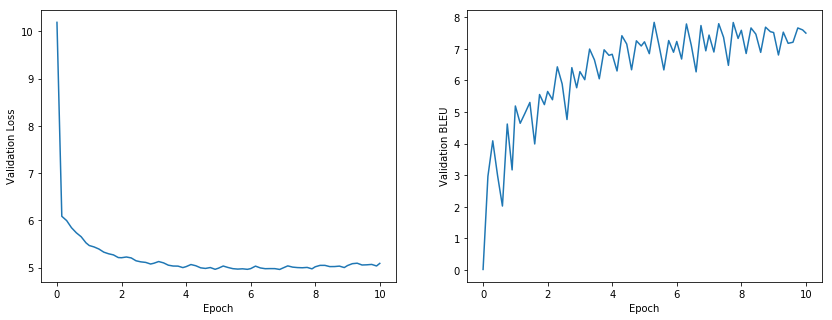

In [11]:
plot_single_learning_curve(experiment_results[0]['results'])

In [16]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                          'total_params', 'trainable_params', 'dt_created']].head(1)

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,zh-rnn-without-attn-2018-12-13 05:27:47,4.963824,7.839494,696.610684,69492144,51492144,2018-12-13 17:04:28


In [17]:
# reload model 
MODEL_NAME_TO_RELOAD = 'zh-rnn-without-attn-2018-12-13 05:27:47'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [18]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

Validation BLEU: 7.84 | Validation Loss: 5.01


In [19]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))

Test BLEU: 8.55 | Test Loss: 4.89
